# Script to plot initial vs final sum(f).

Adapted from previous scripts and formatted to correspond to '210825_boxplots_and_test.py' by Pablo Guridi Fernandez

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import copy
from collections import Counter
from ast import literal_eval
import itertools
from scipy.stats import wilcoxon
from scipy.stats import shapiro

In [2]:
#path evolved communities
#path = "/Users/bvessman/Documents/Mitri/Papers/AST/Figures/Pablo/November/210822/"
#path_ancestral = "/Users/bvessman/Documents/Mitri/Papers/AST/Figures/Pablo/November/211119/"
path = "/Users/pablo/Desktop/code_paper/data/210822/"  
path_ancestral = "/Users/pablo/Desktop/code_paper/data/211119/"  


#some information about these results (210822)
num_repeats=10
num_tubes = 21
rounds = 50
total_sp = 15
rd = 49 #when to take the degradation of evolved communities
#The seeeds we have used for the rng generator and that name the directory to store resutls
seeds = ["22", "23", "24", "25", "26"] #renamed as 1-5 just for the plot
#Propagations to load
#conditions = ["d_s", "d3_s", "p_s", "m_s", "d_r", "d3_r", "p_r", "m_r", "n_r", "pip_s", "pip_r", "mip_s", "mip_r"]
#conditions_rename = ["D4S", "DS", "PS", "MS",  "D4R", "DR", "PR", "MR",  "NS","PIS", "PIR", "MIS", "MIR"]

prop = "d3_s"
#for the final plots we will give different names than those from the model(here IN THE SAME ORDER!)
prop_rename = "DS"

#path where to store the plots
#path_save = "/Users/bvessman/Documents/Mitri/Papers/AST/Figures/"
#path_save = "/home/bvessman/Documents/AST/Pablo/211111_results/f_per_species_diagonal/"
path_save = "/Users/pablo/Desktop/220628_plots_mitri_b/"

In [3]:
#%%LOAD DATA

#Calculate the degradation differentce
dict_deg_diff = {}
dict_deg_evolved = {}
dict_deg_ancestral = {}

dict_AUC_diff = {}
dict_AUC_evolved = {}
dict_AUC_ancestral = {}

for seed in seeds:
    dict_deg_diff[seed] = []
    dict_deg_evolved[seed] = []
    dict_deg_ancestral[seed] = []

    dict_AUC_diff[seed] = []
    dict_AUC_evolved[seed] = []
    dict_AUC_ancestral[seed] = []

    for rp in range(num_repeats):
        df_evolved = pd.read_csv(path + seed + "/" + prop + "/repeat{}/df_grid.csv".format(rp))
        df_evolved = df_evolved.loc[df_evolved["round"] ==rd] #like this we wont include those repeats that went extinct
        #for ancestral data note that we only have one round
        df_ancestral = pd.read_csv(path_ancestral + seed + "/" + prop + "/repeat{}/df_grid.csv".format(rp))
        #calculate the difference for each tube
        diff_tubes = np.subtract(np.array(df_evolved["deg_score"]), np.array(df_ancestral["deg_score"]))

        ### Append degradation score
        dict_deg_diff[seed].append(diff_tubes)
        dict_deg_evolved[seed].extend(list(df_evolved["deg_score"]))
        dict_deg_ancestral[seed].extend(list(df_ancestral["deg_score"]))

        ### Read also AUC
        diff_tubes_auc = np.subtract(np.array(df_evolved["tot_auc"]), np.array(df_ancestral["tot_auc"]))
        dict_AUC_diff[seed].append(diff_tubes_auc)
        dict_AUC_evolved[seed].extend(list(df_evolved["tot_auc"]))
        dict_AUC_ancestral[seed].extend(list(df_ancestral["tot_auc"]))

#%%#Accomodate the information in a dataframe as it will be easier to plot with sns

columns_here= ["seed","prop","repeat",'tube',"deg_diff","auc_diff"]
df = pd.DataFrame( columns = columns_here)
seed_name = 1 #we rename seeds so they appear in the plot starting at 1.
for seed in seeds:
    for repeat in range(num_repeats):
        df_now = pd.DataFrame({"seed":str(seed_name),"prop":prop_rename,
                               "repeat":repeat,'tube':range(num_tubes),
                               "deg_diff":dict_deg_diff[seed][repeat],
                               "auc_diff":dict_AUC_diff[seed][repeat]})
        df = pd.concat([df,df_now])
    seed_name += 1

df_degauc = copy.deepcopy(df)

In [4]:
#### Prepare sum(f)

def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

#I found the predominant combinations in the last round of each 
dict_combs = {}
for seed in seeds:
    list_combs = []
    for repeat in range(num_repeats):
        comb_tubes=[]
        df=pd.read_csv(path + seed + "/" + prop + "/repeat{}/df_sp.csv".format(repeat))
        df = df.loc[df["round"] == rd]
        for tube in range(num_tubes):
            comb_tubes.append(tuple(df.loc[df["tube"] ==tube, "sp"]))
        list_combs.append(most_frequent(comb_tubes))
    dict_combs[seed] = list_combs

storing = {} #store the strains (f values) for now as a tupple now
weights = {} #population sizes of each strain in the dict above
for seed in seeds:
    storing[seed] = {}
    weights[seed] = {}
    for repeat in range(num_repeats):
        storing[seed][str(repeat)] = {}
        weights[seed][str(repeat)] = {}
        df_all = pd.read_csv(path + "{}/{}/repeat{}/df_st.csv".format(seed, prop, repeat))
        #turn the column of fs values into tupple if I haven´t done that in the main scriot already
        df_all['st'] = df_all.st.apply(lambda x: literal_eval(str(x)))
        for rnd in [0, rd]: 
            storing[seed][str(repeat)][str(rnd)] = {}
            weights[seed][str(repeat)][str(rnd)] = {}
            df = df_all.loc[df_all["round"] ==rnd]
            for sp in range(total_sp):
                storing[seed][str(repeat)][str(rnd)][str(sp)] = []
                weights[seed][str(repeat)][str(rnd)][str(sp)] = []
            for tube in range(num_tubes):
                df_here = df.loc[df["tube"] == tube]
                for sp in set(df_here["sp"]): #set(df_here["sp"]): 
                    st = list(df_here.loc[df_here["sp"] == sp, "st"])
                    final_pops = list(df_here.loc[df_here["sp"] == sp, "final_pop"])
                    storing[seed][str(repeat)][str(rnd)][str(sp)].extend(st)
                    weights[seed][str(repeat)][str(rnd)][str(sp)].extend(final_pops)

#Mean sumf weighted by the population of each strain
w_mean_sumf = {}
for seed in seeds:
    w_mean_sumf[seed] = {}
    for repeat in range(num_repeats):
        w_mean_sumf[seed][str(repeat)] = {}
        for sp in range(total_sp):
            w_mean_sumf[seed][str(repeat)][str(sp)] = []
            for rnd in [0, rd]: 
                fs_list = storing[seed][str(repeat)][str(rnd)][str(sp)]
                fs_weights = weights[seed][str(repeat)][str(rnd)][str(sp)]
                sum_sp = [] #actually teh sum and not all the 10 f values
                for fs in fs_list:
                    sum_sp.append(sum(fs))
                if sum_sp:
                    w_mean_sumf[seed][str(repeat)][str(sp)].append(np.average(sum_sp, weights= fs_weights ))
                else:
                    w_mean_sumf[seed][str(repeat)][str(sp)].append(np.nan)

#DO MEAN OVER REPEATS, WHICH IS WHAT I´LL SHOW IN THE PLOT
# when doing the mean over repeats np.nanmean and np.nanstd are used to ignore the nan values
# each species here will have 2 values (mean over repeats), one for round 0 and one for the last round were the species appeared
plot_sumf = {}
for seed in seeds:
    plot_sumf[seed] = {}
    for sp in range(total_sp):
        sp_mean_o_r = [np.nanmean(x) for x in zip(*[w_mean_sumf[seed][str(repeat)][str(sp)] for repeat in range(num_repeats)])]
        #remove the np.nan
        plot_sumf[seed][str(sp)] = [x for x in sp_mean_o_r if np.isnan(x) == False]

#This is not optimal, but well, now I just get a list with initial and final (last round were that species was alive) values for each propagation and seed
#update 221026
f_0 = {}
f_last = {}
f_ancestral = {}
for seed in seeds:
    f_0[seed] = []
    f_last[seed] = []
    f_ancestral[seed] = []
    #load ancestral species
    open_file = open(path + seed + "/d3_s/Species", "rb")
    species = pickle.load(open_file) 
    for sp in range(total_sp):
        new_x = plot_sumf[seed][str(sp)].copy()
        f_0[seed].append(new_x[0])
        f_last[seed].append(new_x[-1])
        f_ancestral[seed].append(sum(species[sp]["fs"]))

    
#Counter of how many times a species in present in the predominant community of the last round
times_in_pc = {}
for seed in seeds:
    list_now = []
    for x in dict_combs[seed]:
        for sp in x:
            list_now.append(int(sp))
    times_in_pc[seed] = Counter(list_now)


#Size of the dots (proportional to how many times a species is in the predominant community)
#Also shape of the dot: circle if a species is in the predominant community (size proportional to how many times), cross otherwise.
#update 221026, change "x" by "X" in markers, adapt a bit the sizes
dot_size={}
dot_shape = {}
for seed in seeds:
    dot_size[seed]=[]
    dot_shape[seed]=[]
    for sp in range(total_sp):
        if sp in times_in_pc[seed].keys():
            dot_size[seed].append(18 + 10*times_in_pc[seed][sp])
            dot_shape[seed].append("o")
        else:
            dot_size[seed].append(20)
            dot_shape[seed].append("X")

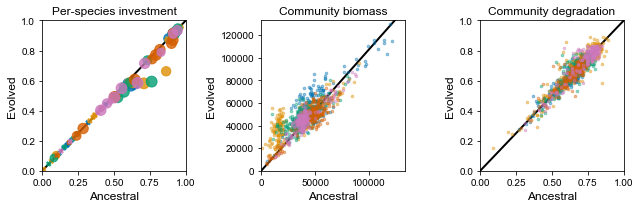

In [5]:
#%%DIAGONAL SCATTER PLOT (this is NOT the version we include in the paper)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
sns.set_style("darkgrid")
plt.rcParams['svg.fonttype'] = "none"

xmin_auc = 0
xmax_auc = 0
ymin_auc = 0
ymax_auc = 0
markers = ["o","X"]
for i_s,seed in enumerate(seeds):
    color_here = sns.color_palette("colorblind")[i_s]
    #we do the difference (comm- sum(mc)) of each tube and then the mean per repeat

    for mark in markers:
        indices = [i for i, x in enumerate(dot_shape[seed]) if x == mark]
        x = [f_0[seed][i] for i in indices]
        y = [f_last[seed][i] for i in indices]
        s = [dot_size[seed][i] for i in indices]
        axes[0].scatter(x,y, color=color_here,s=s,alpha=0.8,marker=mark)

    axes[1].scatter(dict_AUC_ancestral[seed], dict_AUC_evolved[seed],
                    alpha=0.4,color=color_here, marker = "o", s=7)
    axes[2].scatter(dict_deg_ancestral[seed], dict_deg_evolved[seed],
                    alpha=0.4,color=color_here, marker = "o", s=7)

    xmin_auc = np.min([np.min(dict_AUC_ancestral[seed]),xmin_auc])
    xmax_auc = np.max([np.max(dict_AUC_ancestral[seed]),xmax_auc])
    ymin_auc = np.min([np.min(dict_AUC_evolved[seed]),ymin_auc])
    ymax_auc = np.max([np.max(dict_AUC_evolved[seed]),ymax_auc])

axes[0].set_title("Per-species investment",fontsize=12)
axes[0].set_xlabel('Ancestral',fontsize=12)
axes[0].set_ylabel('Evolved',fontsize=12)
axes[1].set_title("Community biomass",fontsize=12)
axes[1].set_xlabel('Ancestral',fontsize=12)
axes[1].set_ylabel('Evolved',fontsize=12)
axes[2].set_title("Community degradation",fontsize=12)
axes[2].set_xlabel('Ancestral',fontsize=12)
axes[2].set_ylabel('Evolved',fontsize=12)

for idxax in [0,2]:
    axes[idxax].plot([-0,1], [-0,1],color = "black",zorder=0, lw=2)
    axes[idxax].set_xlim(0,1)
    axes[idxax].set_ylim(0,1)
    #axtmp.axvline(x=0, color="black", lw=2, linestyle="--",zorder=0)
    #axtmp.axhline(y=0, color="black", lw=2, linestyle="--",zorder=0)

axes[1].plot([0.0,1.1*xmax_auc], [0.0,1.1*ymax_auc],
              color = "black",zorder=0, lw=2)
axes[1].set_xlim(0.0,1.1*xmax_auc)
axes[1].set_ylim(0.0,1.1*xmax_auc)
plt.tight_layout()

fig.savefig(path_save+"evolved_ancestral_deg_diagonal_only"+prop_rename+".pdf",format='pdf')
fig.savefig(path_save+"evolved_ancestral_deg_diagonal_only"+prop_rename+".svg",format='svg')
plt.show()

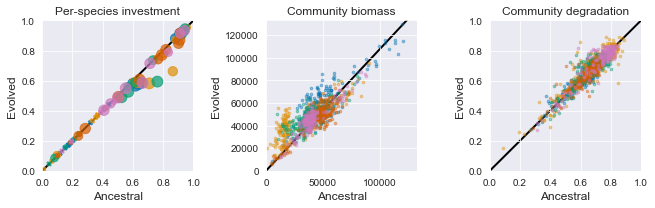

In [6]:
#Update 221026
#same as above, but use the ancestral sum(f) for the first plot instead of the sum(f) at round 0. This is the one we fially include on the paper
#actually there is almost no differnce between this and the previous plot, but the one in this chunk is the one we use.
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(9.2,3))
sns.set_style("darkgrid")
plt.rcParams['svg.fonttype'] = "none"

xmin_auc = 0
xmax_auc = 0
ymin_auc = 0
ymax_auc = 0
markers = ["o","X"]
for i_s,seed in enumerate(seeds):
    color_here = sns.color_palette("colorblind")[i_s]
    #we do the difference (comm- sum(mc)) of each tube and then the mean per repeat

    for mark in markers:
        indices = [i for i, x in enumerate(dot_shape[seed]) if x == mark]
        x = [f_ancestral[seed][i] for i in indices]
        y = [f_last[seed][i] for i in indices]
        s = [dot_size[seed][i] for i in indices]
        axes[0].scatter(x,y, color=color_here,s=s,alpha=0.7,marker=mark)
        #lgnd=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #I´ll have to do the legend manually in inkscape late on, but just to have lower and biger sizes
        #lgnd.legendHandles[0]._sizes = [40+20] #circle, present only once in PC
        #lgnd.legendHandles[1]._sizes = [60] #cross, all of them are the same size
        #lgnd.legendHandles[2]._sizes = [40+20*num_repeats] #circle, present max time in PC
        #lgnd.legendHandles[4]._sizes = [40+20*(num_repeats/2)] #circle, present max time in PC

    axes[1].scatter(dict_AUC_ancestral[seed], dict_AUC_evolved[seed],
                    alpha=0.4,color=color_here, marker = "o", s=7)
    axes[2].scatter(dict_deg_ancestral[seed], dict_deg_evolved[seed],
                    alpha=0.4,color=color_here, marker = "o", s=7)

    xmin_auc = np.min([np.min(dict_AUC_ancestral[seed]),xmin_auc])
    xmax_auc = np.max([np.max(dict_AUC_ancestral[seed]),xmax_auc])
    ymin_auc = np.min([np.min(dict_AUC_evolved[seed]),ymin_auc])
    ymax_auc = np.max([np.max(dict_AUC_evolved[seed]),ymax_auc])

axes[0].set_title("Per-species investment",fontsize=12)
axes[0].set_xlabel('Ancestral',fontsize=12)
axes[0].set_ylabel('Evolved',fontsize=12)
axes[1].set_title("Community biomass",fontsize=12)
axes[1].set_xlabel('Ancestral',fontsize=12)
axes[1].set_ylabel('Evolved',fontsize=12)
axes[2].set_title("Community degradation",fontsize=12)
axes[2].set_xlabel('Ancestral',fontsize=12)
axes[2].set_ylabel('Evolved',fontsize=12)

for idxax in [0,2]:
    axes[idxax].plot([-0,1], [-0,1],color = "black",zorder=0, lw=2)
    axes[idxax].set_xlim(0,1)
    axes[idxax].set_ylim(0,1)
    #axtmp.axvline(x=0, color="black", lw=2, linestyle="--",zorder=0)
    #axtmp.axhline(y=0, color="black", lw=2, linestyle="--",zorder=0)

axes[1].plot([0.0,1.1*xmax_auc], [0.0,1.1*ymax_auc],
              color = "black",zorder=0, lw=2)
axes[1].set_xlim(0.0,1.1*xmax_auc)
axes[1].set_ylim(0.0,1.1*xmax_auc)
plt.tight_layout()

fig.savefig(path_save+"evolved_ancestral_deg_diagonal_only_ok_"+prop_rename+".pdf",format='pdf')
fig.savefig(path_save+"evolved_ancestral_deg_diagonal_only_ok_"+prop_rename+".svg",format='svg')
plt.show()

Degr,  0.0001845144615184161
1
1 0.20819523759198122 0.7918047624080188
mean: -0.0007758818416812789
2
2 0.999986764430452 1.3235569548025935e-05
mean: 0.015129461604182364
3
3 0.9876610415132613 0.012338958486738678
mean: 0.008940785204398992
4
4 0.6616028594161784 0.33839714058382164
mean: 0.00168370011298758
5
5 0.8991305110807005 0.10086948891929948
mean: 0.006288958078443839
Overall mean: 0.006253404631666287


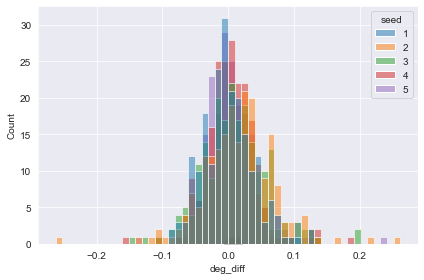

In [7]:
#COMPARE ANCESTRAL AND EVOLVED UNDER SELECTION
df_sw = pd.DataFrame( columns = ["Prop", "Quantity", "sw", "p_val"] )
df_degr = df_degauc.loc[:, ('seed','deg_diff')].reset_index()
swdeg, pdeg = wilcoxon(df_degauc.loc[:, 'deg_diff'],alternative='greater')

print('Degr, ',pdeg)

plt.rcParams['svg.fonttype'] = "none"
sns.set_style("darkgrid")
#axkde = sns.kdeplot(data=df_degr, x="deg_diff", hue="seed")
#plt.tight_layout()
#plt.savefig(path_save + "kdeplot_degr_PCs_220201.pdf".format(y))
axhist = sns.histplot(data=df_degr, x="deg_diff", hue="seed")

arrmeans = np.zeros(5)
for i in range(5):
    seed = i+1
    
    print(seed)
    dftmp = df_degauc.loc[df_degauc.seed==str(seed),'deg_diff']
    swless, pless = wilcoxon(dftmp,alternative='less')
    swgr, pgreater = wilcoxon(dftmp,alternative='greater')
    
    arrmeans[i] = np.mean(dftmp)
    axhist.scatter(x=arrmeans,y=0.2+np.zeros(5),s=100,c='k',marker='^')
    print(seed, pless, pgreater)
    print('mean: '+str(np.mean(dftmp)))

plt.tight_layout()
plt.savefig(path_save + "histplot_degr_PCs"+prop_rename+"_220920.pdf")
plt.savefig(path_save + "histplot_degr_PCs"+prop_rename+"_220920.svg")

print('Overall mean: '+str(np.mean(df_degauc.deg_diff)))


In [8]:
#COMPARE ANCESTRAL AND EVOLVED UNDER SELECTION
df_sw = pd.DataFrame( columns = ["Prop", "Quantity", "sw", "p_val"] )

df_degr = df_degauc.loc[:, 'deg_diff']
df_auc  = df_degauc.loc[:, 'auc_diff']

swdeg, pdeg = wilcoxon(df_degr,alternative='greater')
swauc, pauc = wilcoxon(df_auc,alternative='greater')

Nseeds = len(seeds)
arr_f0    = np.zeros(total_sp*Nseeds)
arr_flast = np.zeros(total_sp*Nseeds)
for idxs,s in enumerate(seeds):
    idx1 = idxs*total_sp
    idx2 = (idxs+1)*total_sp
    arr_f0[idx1:idx2] = f_ancestral[s][:]
    arr_flast[idx1:idx2] = f_last[s][:]
swf, pf = wilcoxon(arr_f0,arr_flast,alternative='greater')

print('Degr, ',pdeg)
print('AUC, ',pauc)
print('sumf, ',pf)

df_sw = pd.DataFrame({"Prop":[prop,prop,prop],"Quantity":['Degr','AUC','sumf'],
                      "sw":[swdeg,swauc,swf], "p_val":[pdeg,pauc,pf]})
df_sw.to_csv(path_save + "dfsw_degr_auc_ancVSevol"+prop_rename+".csv")

Degr,  0.0001845144615184161
AUC,  6.701915478405667e-106
sumf,  3.5530218512850654e-07


In [9]:
### Arrange dataframe with all species sets and repeats 
dict_sumf_all = {}
for seed in seeds:
    dict_sumf_all[seed] = {}
    for repeat in range(num_repeats):
        dict_sumf_all[seed][str(repeat)] = {}
        for sp in range(total_sp):
            values = [w_mean_sumf[seed][str(repeat)][str(sp)]]
            #print(values)
            sp_mean_o_r = [np.nanmean(x) for x in zip(*values)]
            dict_sumf_all[seed][str(repeat)][str(sp)] = [x for x in sp_mean_o_r if np.isnan(x) == False]

#This is not optimal, but well, now I just get a list with initial and final (last round were that species was alive) values for each propagation and seed
f_0 = {}
f_last = {}
for seed in seeds:
    f_0[seed] = []
    f_last[seed] = []
    for repeat in dict_sumf_all[seed].keys():
        for spec in dict_sumf_all[seed][str(repeat)].values():
            new_x=x 
            f_0[seed].append(new_x[0])
            f_last[seed].append(new_x[-1])

<ipython-input-9-67c920b767d8>:10: RuntimeWarning: Mean of empty slice
  sp_mean_o_r = [np.nanmean(x) for x in zip(*values)]


In [10]:
#COMPARE ANCESTRAL AND EVOLVED UNDER SELECTION
df_sw = pd.DataFrame( columns = ["Prop", "Quantity", "sw", "p_val"] )

df_degr = df_degauc.loc[:, 'deg_diff']
df_auc  = df_degauc.loc[:, 'auc_diff']

swdeg, pdeg = wilcoxon(df_degr,alternative='greater')
swauc, pauc = wilcoxon(df_auc,alternative='greater')

Nseeds = len(seeds)
arr_f0    = np.zeros(total_sp*Nseeds*num_repeats)
arr_flast = np.zeros(total_sp*Nseeds*num_repeats)
for idxs,s in enumerate(seeds):
    idx1 = idxs*total_sp*num_repeats
    idx2 = (idxs+1)*total_sp*num_repeats
    arr_f0[idx1:idx2] = f_0[s][:]
    arr_flast[idx1:idx2] = f_last[s][:]
swf, pf = wilcoxon(arr_f0,arr_flast,alternative='less')

df_sw = pd.DataFrame({"Prop":[prop,prop,prop],"Quantity":['Degr','AUC','sumf'],
                      "sw":[swdeg,swauc,swf], "p_val":[pdeg,pauc,pf]})
df_sw.to_csv(path_save + "dfsw_degr_auc_ancVSevol_"+prop_rename+"_noav.csv")

In [11]:
print(df_sw)

   Prop Quantity        sw          p_val
0  d3_s     Degr  310891.0   1.845145e-04
1  d3_s      AUC  490403.5  6.701915e-106
2  d3_s     sumf       0.0  2.006188e-165
